## Conditional Workflow (Beginner Friendly)

### Conditional workflow kya hota hai?
Simple: graph run hota hai, phir beech mein **if/else jaisa decision** hota hai aur flow **branch A** ya **branch B** mein chala jata hai.

### 3 core cheezen
- **State**: aik dict jisme data hota hai (e.g. `{ "name": "Ali", "score": 78 }`).
- **Node**: aik function/step jo state ko read karta hai aur **partial update** return karta hai (e.g. `{ "result": "PASS" }`).
- **Router/Decider**: aik function jo state dekh kar **route key** return karta hai (e.g. `"pass"` ya `"fail"`).

### Flow ka mental model
```
START -> (router decision) -> pass_node  -> END
                       \-> fail_node  -> END
```

### `add_conditional_edges` ka matlab
Aap router ke return ko node-name ke saath map karte ho:
- Router returns `"pass"`  -> next node = `"pass"`
- Router returns `"fail"`  -> next node = `"fail"`

Is notebook mein hum 2 ways dekhenge:
- **Method 1**: START se direct routing
- **Method 2**: Pehle `router` node, phir routing (debug friendly)


## Non-LLM Based Workflow (Score Based)

Goal: agar `score >= 50` ho to **PASS**, warna **FAIL**.

- **No LLM**: sirf normal Python logic.
- **Input state**: `{name, score}`
- **Output state**: `{result, message}` (plus original fields preserved)


In [1]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

In [2]:
# SimpleState = woh data jo graph ke andar pass hota hai
# total=False => sab keys required nahi; nodes partial updates return kar sakte hain
class SimpleState(TypedDict, total=False):
    name: str
    score: int
    result: str
    message: str

In [3]:
# Router function: is ka return MUST mapping keys mein se aik hona chahiye
# yahan hum "pass" ya "fail" return kar rahe hain
def route_by_score(state: SimpleState) -> str:
    score = state.get("score", 0)
    return "pass" if score >= 50 else "fail"


# Node: PASS branch
# Note: node input state ko mutate nahi kar raha; sirf partial update return karta hai
def pass_node(state: SimpleState) -> SimpleState:
    return {
        "result": "PASS",
        "message": f"{state.get('name', 'Student')} passed with score {state.get('score', 0)}.",
    }


# Node: FAIL branch
def fail_node(state: SimpleState) -> SimpleState:
    return {
        "result": "FAIL",
        "message": f"{state.get('name', 'Student')} failed with score {state.get('score', 0)}.",
    }

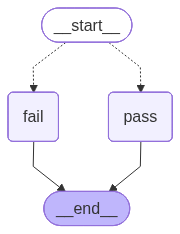

In [4]:
# ---------
# Method 1: START se direct conditional routing
# ---------

graph = StateGraph(SimpleState)

# Nodes add kar rahe hain
graph.add_node("pass", pass_node)
graph.add_node("fail", fail_node)

# START se router function chalega aur router ki return ke basis pe next node choose hoga
# Mapping: "pass" -> "pass" node, "fail" -> "fail" node
graph.add_conditional_edges(START, route_by_score, {"pass": "pass", "fail": "fail"})

# Branches ka end
graph.add_edge("pass", END)
graph.add_edge("fail", END)

workflow = graph.compile()
workflow

In [5]:
# Visualize graph (pehle)
print("\nGraph (ASCII):")
print(workflow.get_graph().draw_ascii())

# Dry-run: router kya return karega?
ali = {"name": "Ali", "score": 78}
sara = {"name": "Sara", "score": 35}
print("\nRouter decision:")
print("Ali ->", route_by_score(ali))
print("Sara ->", route_by_score(sara))

# Run examples (phir)
print("\nWorkflow output:")
print(workflow.invoke(ali))
print(workflow.invoke(sara))


Graph (ASCII):
      +-----------+      
      | __start__ |      
      +-----------+      
        .       .        
      ..         ..      
     .             .     
+------+        +------+ 
| fail |        | pass | 
+------+        +------+ 
        *       *        
         **   **         
           * *           
      +---------+        
      | __end__ |        
      +---------+        

Router decision:
Ali -> pass
Sara -> fail

Workflow output:
{'name': 'Ali', 'score': 78, 'result': 'PASS', 'message': 'Ali passed with score 78.'}
{'name': 'Sara', 'score': 35, 'result': 'FAIL', 'message': 'Sara failed with score 35.'}


## Method 2: Router Node (explicit) — beginner view

Is method mein hum pehle aik node `router` chalate hain:
- `router` state dekh kar **`route`** field set karta hai (e.g. `"pass"` ya `"fail"`).
- Phir `add_conditional_edges` **router node** ke baad routing karta hai.

**Iska faida**:
- aap final output mein `route` dekh sakte ho → "kyun pass/fail hua" clear hota hai.


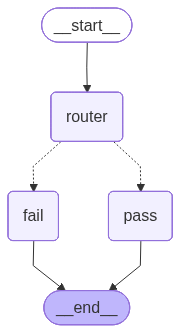

In [6]:
from typing import Literal


# RoutedState: SimpleState + extra field "route"
class RoutedState(SimpleState, total=False):
    route: Literal["pass", "fail"]


# Node 1: router (decision ko state mein store karta hai)
def router_node(state: RoutedState) -> RoutedState:
    route = "pass" if state.get("score", 0) >= 50 else "fail"
    return {"route": route}


# Conditional function: state se route read karke next node choose karwana
def read_route(state: RoutedState) -> str:
    return state.get("route", "fail")


graph2 = StateGraph(RoutedState)

# Nodes
graph2.add_node("router", router_node)
graph2.add_node("pass", pass_node)
graph2.add_node("fail", fail_node)

# Flow
graph2.add_edge(START, "router")

graph2.add_conditional_edges(
    "router",
    read_route,
    {"pass": "pass", "fail": "fail"},
)

graph2.add_edge("pass", END)
graph2.add_edge("fail", END)

workflow2 = graph2.compile()
workflow2


In [7]:
# Visualize graph2
print("\nGraph2 (ASCII):")
print(workflow2.get_graph().draw_ascii())

# Run examples
hassan = {"name": "Hassan", "score": 51}
ayesha = {"name": "Ayesha", "score": 12}

print("\nWorkflow2 output (notice `route`):")
print(workflow2.invoke(hassan))
print(workflow2.invoke(ayesha))


Graph2 (ASCII):
      +-----------+      
      | __start__ |      
      +-----------+      
            *            
            *            
            *            
       +--------+        
       | router |        
       +--------+        
        .       .        
      ..         ..      
     .             .     
+------+        +------+ 
| fail |        | pass | 
+------+        +------+ 
        *       *        
         **   **         
           * *           
      +---------+        
      | __end__ |        
      +---------+        

Workflow2 output (notice `route`):
{'name': 'Hassan', 'score': 51, 'result': 'PASS', 'message': 'Hassan passed with score 51.', 'route': 'pass'}
{'name': 'Ayesha', 'score': 12, 'result': 'FAIL', 'message': 'Ayesha failed with score 12.', 'route': 'fail'}
